In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-28 10:41:57.826899: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "../dataset_3/training"
val_path = "../dataset_3/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-28 10:41:59.993501: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 10:42:00.402396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 34130 files belonging to 3 classes.
Found 4282 files belonging to 3 classes.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


### Test set

In [5]:
with tf.device("CPU"):
    AUTOTUNE = tf.data.AUTOTUNE
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [6]:
print(len(validation_dataset))
print(len(test_dataset))

67
67


## Model building

In [7]:
def lenet(dropout_num):
    model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=img_shape),
    Dropout(dropout_num),
    MaxPooling2D((2, 2)),
        
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(dropout_num),
    MaxPooling2D((2, 2)),
    MaxPooling2D((2, 2)),   
        
    Flatten(),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
#     Dropout(dropout_num),
    Dense(3, activation='softmax')
])
    return model

In [12]:
with tf.device("GPU"):
    model = lenet(0.2)

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 182, 214, 8)       224       
                                                                 
 dropout_2 (Dropout)         (None, 182, 214, 8)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 91, 107, 8)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 89, 105, 16)       1168      
                                                                 
 dropout_3 (Dropout)         (None, 89, 105, 16)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 44, 52, 16)       0         
 2D)                                                  

## Model training

In [14]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [15]:
EPOCH = 150

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/150
1067/1067 [==============================] - 16s 14ms/step - loss: 1.6546 - accuracy: 0.7149 - val_loss: 1.0654 - val_accuracy: 0.5065
Epoch 2/150
1067/1067 [==============================] - 15s 14ms/step - loss: 0.4524 - accuracy: 0.8115 - val_loss: 1.1079 - val_accuracy: 0.5313
Epoch 3/150
1067/1067 [==============================] - 15s 14ms/step - loss: 0.3852 - accuracy: 0.8391 - val_loss: 1.1849 - val_accuracy: 0.5070
Epoch 4/150
1067/1067 [==============================] - 15s 14ms/step - loss: 0.3504 - accuracy: 0.8534 - val_loss: 1.2834 - val_accuracy: 0.4261
Epoch 5/150
1067/1067 [==============================] - 15s 14ms/step - loss: 0.3152 - accuracy: 0.8698 - val_loss: 1.3410 - val_accuracy: 0.4317
Epoch 6/150
1067/1067 [==============================] - 15s 14ms/step - loss: 0.2802 - accuracy: 0.8850 - val_loss: 1.2267 - val_accuracy: 0.4897
Epoch 7/150
1067/1067 [==============================] - 15s 14ms/step - loss: 0.2624 - accuracy: 0.8926 - val_loss: 1

### Training evaluation

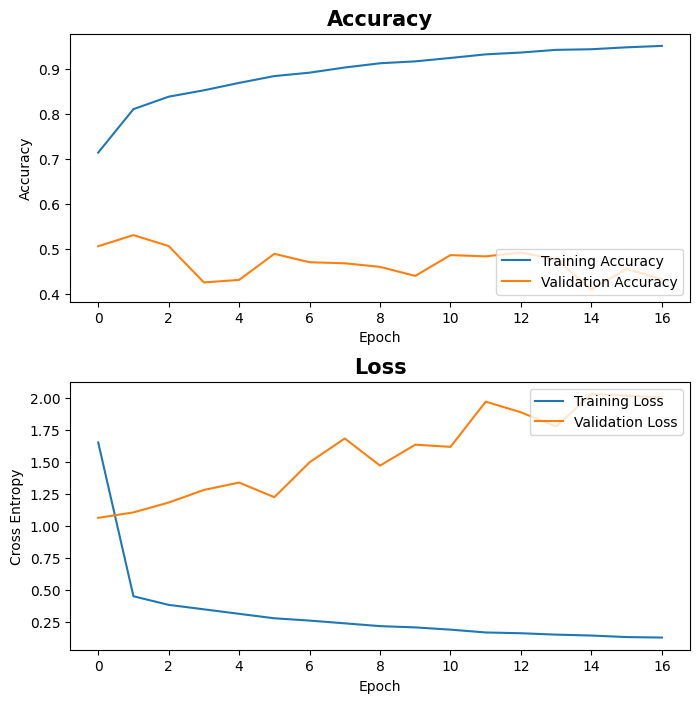

In [16]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')

plt.subplots_adjust(hspace=0.3)
plt.show()

## Testing

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [18]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

67/67 [==============================] - 1s 7ms/step - loss: 1.9976 - accuracy: 0.4277


{'loss': 1.9976259469985962, 'accuracy': 0.42770522832870483}

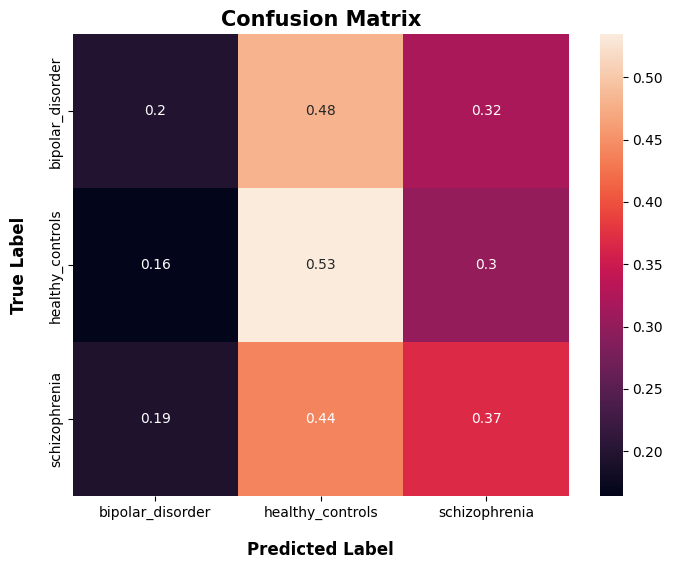

In [19]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./lenet3_cm.png')
plt.show()

In [20]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.42770522832870483
Precision: 0.4441345704407472
Sensitivity: 0.4239738805970149
Specificity: 0.6832788400623624
